# Analyze Japan Airlines Passenger Satisfaction using IBM Granite

In [1]:
!pip install replicate


1.   Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import replicate     # untuk akses model Granite via Replicate API
import json          # untuk mengatur data evaluasi yang akan dikirim ke LLM
import textwrap      # untuk memformat prompt analisa
import os            # untuk akses environment variable (REPLICATE_API_TOKEN)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

2.   Load Data

In [4]:
pd.set_option("display.max_column",100)

In [5]:
try:
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
    print("✅ Data berhasil dimuat!")
except FileNotFoundError:
    print("❌ File tidak ditemukan. Pastikan train.csv dan test.csv ada di direktori kerja.")

✅ Data berhasil dimuat!


In [6]:
df_test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


3.   EDA Analyze

In [7]:
print("Rows: ",df_test.shape[0] + df_train.shape[0])
print("Columns: ", df_train.shape[1])

Rows:  129880
Columns:  25


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [9]:
df_train.isnull().sum()

,0
Unnamed: 0,0
id,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Inflight wifi service,0
Departure/Arrival time convenient,0


In [10]:
df_train.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [11]:
df_train.drop(["Unnamed: 0","id"],axis=1, inplace=True)
df_test.drop(["Unnamed: 0","id"],axis=1,inplace=True)

In [12]:
for col in ["Gender","Customer Type","Type of Travel","satisfaction","Class"]:
    print(df_train[col].unique())

['Male' 'Female']
['Loyal Customer' 'disloyal Customer']
['Personal Travel' 'Business travel']
['neutral or dissatisfied' 'satisfied']
['Eco Plus' 'Business' 'Eco']


In [13]:
df_train['satisfaction'] = df_train["satisfaction"].map({"neutral or dissatisfied":0, "satisfied":1})
df_train['satisfaction'] = df_train['satisfaction'].astype(int)

df_test['satisfaction'] = df_test["satisfaction"].map({"neutral or dissatisfied":0, "satisfied":1})
df_test['satisfaction'] = df_test['satisfaction'].astype(int)

In [14]:
df_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


In [15]:
df_train.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678,0.433333
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682,0.495538
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


In [16]:
len(df_train[df_train['Arrival Delay in Minutes'] == 0])

58159

In [17]:
df_train['Arrival Delay in Minutes'].nunique()

455

In [18]:
df_train['Arrival Delay in Minutes'] = df_train['Arrival Delay in Minutes'].fillna(df_train['Arrival Delay in Minutes'].mean())
df_test['Arrival Delay in Minutes'] = df_test['Arrival Delay in Minutes'].fillna(df_test['Arrival Delay in Minutes'].mean())

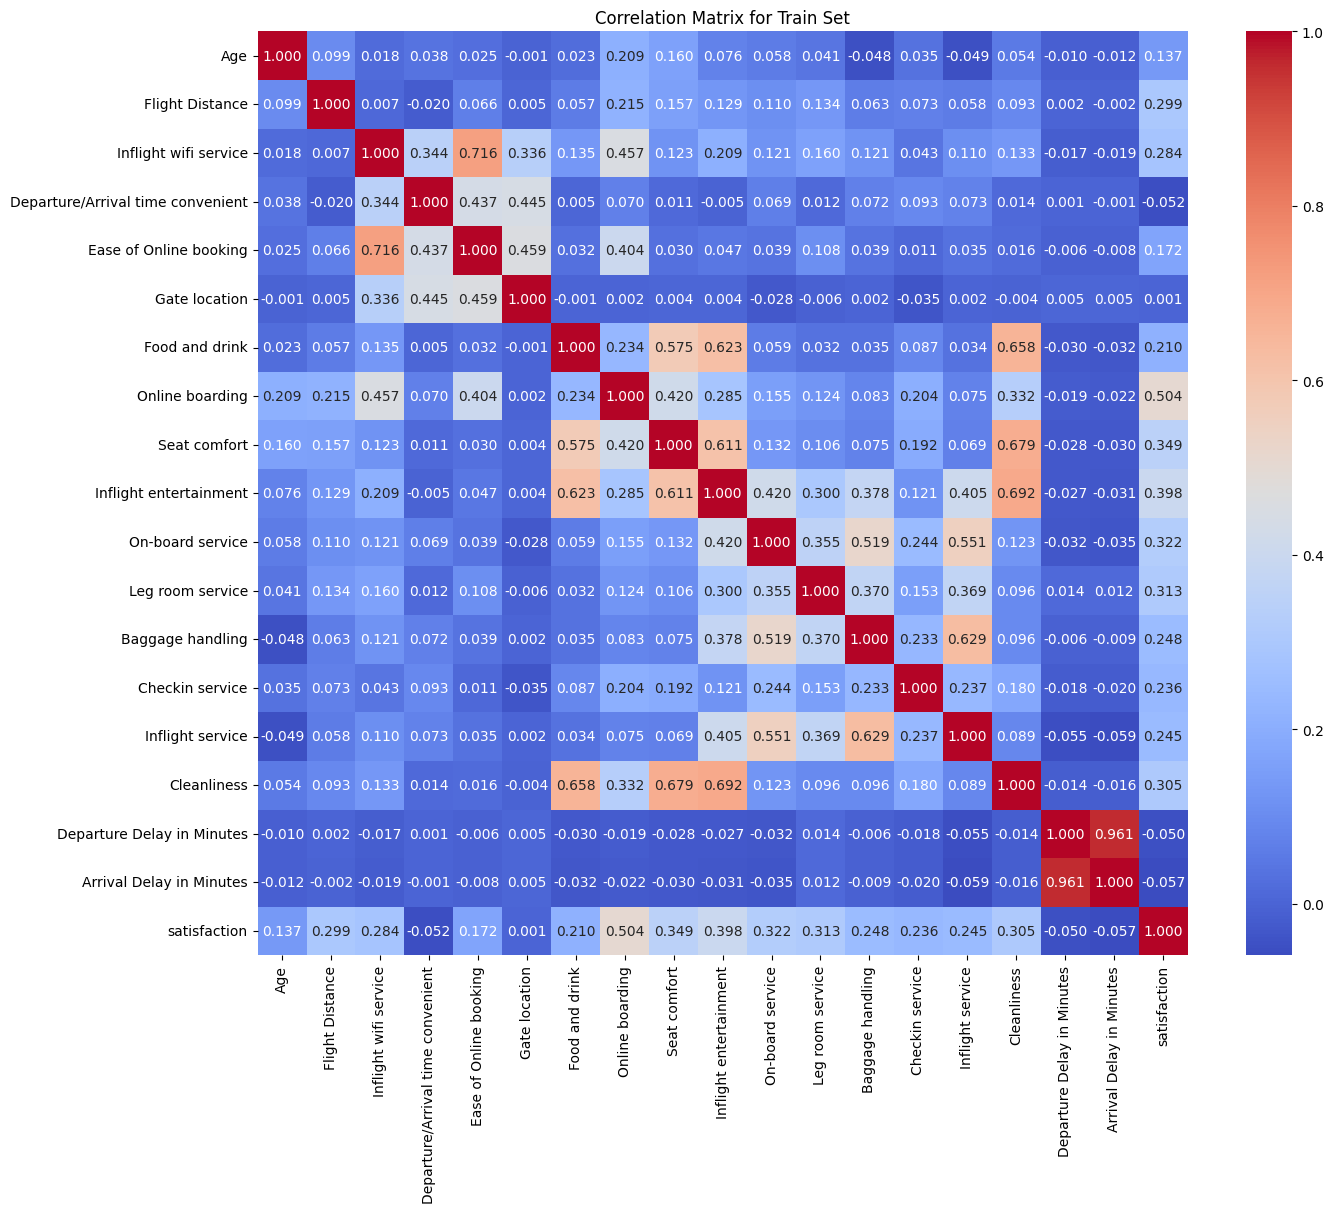

In [19]:
#Correlation
plt.figure(figsize=(15,12))
sns.heatmap(data=df_train.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation Matrix for Train Set")
plt.show()

In [20]:
# === Analisis Otomatis EDA Menggunakan IBM Granite ===

def analyze_eda_with_granite(df):
    """
    Mengirim ringkasan EDA ke model IBM Granite via Replicate untuk mendapatkan analisis otomatis.
    """
    # Ringkasan data
    summary = df.describe(include='all').to_string()
    missing = df.isnull().sum().to_string()
    cols = ", ".join(df.columns)

    prompt = textwrap.dedent(f"""
    Anda adalah seorang data scientist ahli.
    Berikut hasil Exploratory Data Analysis (EDA) dari dataset kepuasan penumpang Japan Airlines:

    Jumlah baris: {len(df)}
    Jumlah kolom: {len(df.columns)}
    Daftar kolom: {cols}

    Nilai yang hilang per kolom:
    {missing}

    Statistik deskriptif:
    {summary}

    Berdasarkan data di atas, berikan analisa yang mencakup:
    1. Pola penting atau korelasi antar variabel.
    2. Potensi masalah pada data (outlier, data imbalance, missing value).
    3. Insight bisnis yang mungkin muncul dari pola data.
    4. Rekomendasi preprocessing sebelum pelatihan model ML.

    Berikan hasil analisa dengan penjelasan yang jelas dan sistematis.
    """)

    print("🔄 Mengirim ringkasan EDA ke Granite untuk analisa...\n")

    output = replicate.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={"prompt": prompt}
    )

    print("✅ Analisis dari IBM Granite:\n")
    print("".join(output))


# Jalankan fungsi ini untuk mendapatkan analisa otomatis Granite
analyze_eda_with_granite(df_train)


🔄 Mengirim ringkasan EDA ke Granite untuk analisa...

✅ Analisis dari IBM Granite:

Based on the provided Exploratory Data Analysis (EDA) of the Japan Airlines passenger satisfaction dataset, here's a detailed analysis:

1. **Important Patterns or Correlations**:
   - **Age**: The mean age of passengers is approximately 39.4 years. The median age is 40 years, indicating a somewhat symmetric distribution. There's no significant skewness, as the 25th percentile (27) is close to the median (40), and the 75th percentile (51) is relatively close as well.
   - **Class**: Most passengers seem to travel in Business class (49,665 instances), followed by Economy (likely, as it's not explicitly mentioned but implied by the missing value in 'Class' column).
   - **Flight Distance**: The mean flight distance is about 1189.448 km, with a maximum of 4983 km. This suggests both domestic and international flights.
   - **Satisfaction**: The satisfaction score has a mean of 3.286, indicating generally p

In [21]:
def correlation_for_dropping(df, threshold):
    columns_to_drop = set()
    corr = df.corr(numeric_only=True)
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                colname = corr.columns[i]
                columns_to_drop.add(colname)
    return columns_to_drop

correlation_for_dropping(df_train, 0.9)

{'Arrival Delay in Minutes'}

4.   Check Outliers Values

In [22]:
def find_outliers_iqr(df, threshold):
    outlier_summary = {}
    numeric_cols = df.select_dtypes("number")

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        outlier_summary[col] = {
            "Outlier Count " : outliers.shape,
            "Outlier Percentage" : 100 * outliers.shape[0] / df.shape[0],
            "Lower Bound" : lower_bound,
            "Upper Bound" : upper_bound
        }

    return pd.DataFrame(outlier_summary)

find_outliers_iqr(df_train, threshold=1.5)

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
Outlier Count,"(0, 23)","(2291, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(12891, 23)","(0, 23)","(0, 23)","(14529, 23)","(13954, 23)","(0, 23)"
Outlier Percentage,0.0,2.20492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.406645,0.0,0.0,13.9831,13.429704,0.0
Lower Bound,-9.0,-1579.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.5,-1.0,-1.0,-1.0,0.0,1.5,0.0,-1.0,-18.0,-19.5,-1.5
Upper Bound,87.0,3736.5,7.0,7.0,7.0,7.0,7.0,7.0,9.5,7.0,7.0,7.0,8.0,5.5,8.0,7.0,30.0,32.5,2.5


In [23]:
# === Analisis Outlier Menggunakan IBM Granite ===

def analyze_outliers_with_granite(df, threshold=1.5):
    """
    Mengirim ringkasan hasil deteksi outlier ke IBM Granite untuk mendapatkan analisis otomatis.
    """
    outlier_summary_df = find_outliers_iqr(df, threshold)
    summary_text = outlier_summary_df.to_string()

    prompt = textwrap.dedent(f"""
    Anda adalah seorang data scientist ahli.
    Berikut adalah hasil deteksi outlier menggunakan metode IQR (Interquartile Range)
    pada dataset kepuasan penumpang Japan Airlines (threshold = {threshold}):

    {summary_text}

    Berdasarkan data ini:
    1. Jelaskan variabel mana yang paling berisiko memiliki outlier signifikan.
    2. Berikan interpretasi penyebab potensial munculnya outlier pada variabel tersebut.
    3. Rekomendasikan pendekatan penanganan outlier yang paling sesuai
       (misalnya transformasi, winsorizing, capping, atau penghapusan data).
    4. Berikan saran bagaimana outlier dapat mempengaruhi performa model ML dan cara mitigasinya.
    """)

    print("🔄 Mengirim hasil deteksi outlier ke Granite untuk analisa...\n")

    output = replicate.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={"prompt": prompt}
    )

    print("✅ Analisis dari IBM Granite:\n")
    print("".join(output))


# Jalankan fungsi ini untuk mendapatkan analisis otomatis Granite
analyze_outliers_with_granite(df_train, threshold=1.5)


🔄 Mengirim hasil deteksi outlier ke Granite untuk analisa...

✅ Analisis dari IBM Granite:

1. Variabel yang paling berrisiko memiliki outlier signifikan adalah "Departure/Arrival time convenient" dengan jumlah outlier sebanyak 13.9831% dari total data.

2. Penyebab potensial munculnya outlier pada variabel ini dapat disebabkan oleh ketergantungan kesulitan waktu keberangkatan/angkutan terhadap faktor-faktor yang dikenal tidak atau sulit dikontrol, seperti kebimbangan lingkungan, kebimbangan keamanan, atau kebimbangan lainnya yang tidak terdokumentasikan dalam dataset. Outlier ini mungkin juga disebabkan oleh kesalahan data, misalnya kesalahan dalam masukkan waktu keberangkatan/angkutan yang sangat panjang atau sangat singkat.

3. Pendekatan penanganan outlier yang paling sesuai untuk variabel ini adalah penghapusan data. Karena outlier tersebut merupakan kesalahan data yang signifikan dan tidak dibelumkan oleh faktor-faktor yang dianalisis, pengeluaran outlier ini dapat membuat datase

In [24]:
find_outliers_iqr(df_test, threshold=1.5)

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
Outlier Count,"(0, 23)","(584, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(0, 23)","(3218, 23)","(0, 23)","(0, 23)","(3569, 23)","(3538, 23)","(0, 23)"
Outlier Percentage,0.0,2.248229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.388358,0.0,0.0,13.739606,13.620265,0.0
Lower Bound,-9.0,-1581.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.5,-1.0,-1.0,-1.0,0.0,1.5,0.0,-1.0,-18.0,-19.5,-1.5
Upper Bound,87.0,3739.0,7.0,7.0,7.0,7.0,7.0,7.0,9.5,7.0,7.0,7.0,8.0,5.5,8.0,7.0,30.0,32.5,2.5


5.   Train-Test Split

In [25]:
X_train = df_train.drop("satisfaction",axis=1)
y_train = df_train["satisfaction"]

X_test = df_test.drop("satisfaction", axis=1)
y_test = df_test["satisfaction"]

6.   Data Preparation

In [26]:
cols_to_scale = X_train.select_dtypes("number").columns
cols_to_encode = X_train.select_dtypes(exclude=["number"]).columns

preprocessor = ColumnTransformer(transformers=[
    ("encoder",OneHotEncoder(handle_unknown="ignore",drop="first",sparse_output=False),cols_to_encode),
    ("scaler",StandardScaler(),cols_to_scale)
], remainder="passthrough"
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

names = preprocessor.get_feature_names_out()

X_train_transformed = pd.DataFrame(X_train_transformed, columns=names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=names)

In [27]:
X_train_transformed.head()

,encoder__Gender_Male,encoder__Customer Type_disloyal Customer,encoder__Type of Travel_Personal Travel,encoder__Class_Eco,encoder__Class_Eco Plus,scaler__Age,scaler__Flight Distance,scaler__Inflight wifi service,scaler__Departure/Arrival time convenient,scaler__Ease of Online booking,scaler__Gate location,scaler__Food and drink,scaler__Online boarding,scaler__Seat comfort,scaler__Inflight entertainment,scaler__On-board service,scaler__Leg room service,scaler__Baggage handling,scaler__Checkin service,scaler__Inflight service,scaler__Cleanliness,scaler__Departure Delay in Minutes,scaler__Arrival Delay in Minutes
0,1.0,0.0,1.0,0.0,1.0,-1.745279,-0.731539,0.203579,0.616172,0.173776,-1.547323,1.352264,-0.185532,1.183099,1.231704,0.479403,-0.26684,0.311769,0.549799,1.156436,1.305870,0.266393,0.073014
1,1.0,1.0,0.0,0.0,0.0,-0.951360,-0.957184,0.203579,-0.695245,0.173776,0.018094,-1.656326,-0.185532,-1.849315,-1.769081,-1.849161,1.25338,-0.535045,-1.821012,0.305848,-1.742292,-0.361375,-0.237539
2,0.0,0.0,0.0,0.0,0.0,-0.885200,-0.047584,-0.549533,-0.695245,-0.541060,-0.764614,1.352264,1.296496,1.183099,1.231704,0.479403,-0.26684,0.311769,0.549799,0.305848,1.305870,-0.387532,-0.392816
3,0.0,0.0,0.0,0.0,0.0,-0.951360,-0.629246,-0.549533,1.271880,1.603448,1.583511,-0.904178,-0.926545,-1.091211,-1.018885,-1.072973,1.25338,-0.535045,-1.821012,0.305848,-0.980251,-0.099805,-0.159901
4,1.0,0.0,0.0,0.0,0.0,1.430397,-0.978244,0.203579,-0.039537,0.173776,0.018094,0.600117,1.296496,1.183099,-0.268688,-0.296785,0.49327,0.311769,-0.240472,-0.544740,-0.218211,-0.387532,-0.392816


7.   Training Models

In [28]:
def calculate_model_metric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    classification = classification_report(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)

    return accuracy, classification, matrix

Train Evaluation for Logistic Regression: 
Accuracy Score: 0.8752 

Classification Report: 

               precision    recall  f1-score   support

           0       0.88      0.90      0.89     58879
           1       0.87      0.84      0.85     45025

    accuracy                           0.88    103904
   macro avg       0.87      0.87      0.87    103904
weighted avg       0.88      0.88      0.87    103904

Confusion Matrix: 
 [[53282  5597]
 [ 7375 37650]]


Test Evaluation for Logistic Regression: 
Accuracy Score: 0.8717 

Classification Report: 

               precision    recall  f1-score   support

           0       0.87      0.90      0.89     14573
           1       0.87      0.83      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976

Confusion Matrix: 
 [[13142  1431]
 [ 1901  9502]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

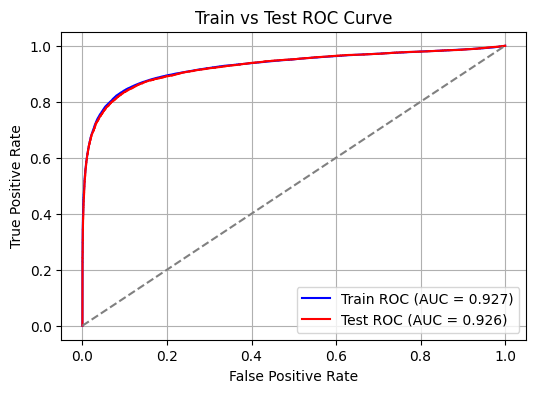

Train Evaluation for Random Forest Classifier: 
Accuracy Score: 1.0000 

Classification Report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     58879
           1       1.00      1.00      1.00     45025

    accuracy                           1.00    103904
   macro avg       1.00      1.00      1.00    103904
weighted avg       1.00      1.00      1.00    103904

Confusion Matrix: 
 [[58879     0]
 [    0 45025]]


Test Evaluation for Random Forest Classifier: 
Accuracy Score: 0.9618 

Classification Report: 

               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.94      0.96     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

Confusion Matrix: 
 [[14246   327]
 [  664 10739]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

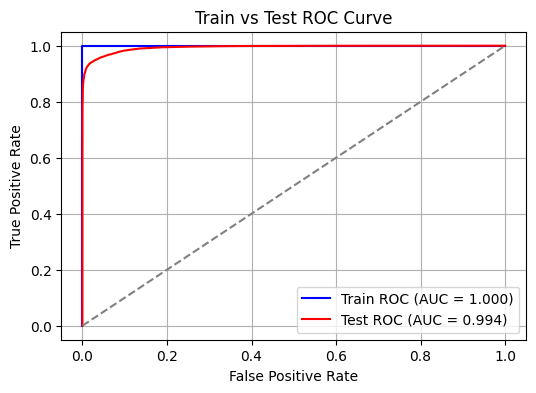

Train Evaluation for Gradient Boost Classifier: 
Accuracy Score: 0.9406 

Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.96      0.95     58879
           1       0.94      0.92      0.93     45025

    accuracy                           0.94    103904
   macro avg       0.94      0.94      0.94    103904
weighted avg       0.94      0.94      0.94    103904

Confusion Matrix: 
 [[56435  2444]
 [ 3732 41293]]


Test Evaluation for Gradient Boost Classifier: 
Accuracy Score: 0.9404 

Classification Report: 

               precision    recall  f1-score   support

           0       0.94      0.96      0.95     14573
           1       0.95      0.92      0.93     11403

    accuracy                           0.94     25976
   macro avg       0.94      0.94      0.94     25976
weighted avg       0.94      0.94      0.94     25976

Confusion Matrix: 
 [[13965   608]
 [  940 10463]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

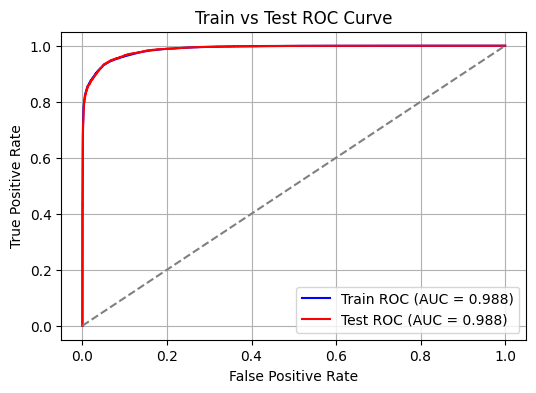

Train Evaluation for XGBoost Classifier: 
Accuracy Score: 0.9747 

Classification Report: 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98     58879
           1       0.98      0.96      0.97     45025

    accuracy                           0.97    103904
   macro avg       0.98      0.97      0.97    103904
weighted avg       0.97      0.97      0.97    103904

Confusion Matrix: 
 [[58150   729]
 [ 1899 43126]]


Test Evaluation for XGBoost Classifier: 
Accuracy Score: 0.9635 

Classification Report: 

               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.94      0.96     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

Confusion Matrix: 
 [[14258   315]
 [  633 10770]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

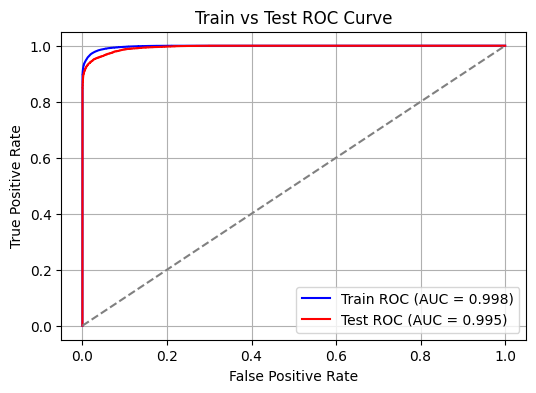

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 45025, number of negative: 58879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 103904, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433333 -> initscore=-0.268267
[LightGBM] [Info] Start training from score -0.268267
Train Evaluation for LightGBM Classifier: 
Accuracy Score: 0.9658 

Classification Report: 

               precision    recall  f1-score   support

           0       0.96      0.98      0.97     58879
           1       0.98      0.94      0.96     45025

    accuracy                           0.97    103904
   macro avg       0.97      0.96      0.97    103

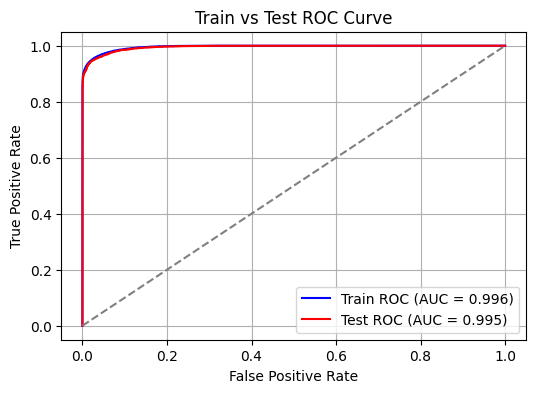

In [29]:
models = {
    "Logistic Regression" : LogisticRegression(),
    "Random Forest Classifier" : RandomForestClassifier(n_jobs=-1),
    "Gradient Boost Classifier" : GradientBoostingClassifier(),
    "XGBoost Classifier" : XGBClassifier(),
    "LightGBM Classifier" : LGBMClassifier(n_jobs=-1)
}

for name, model in models.items():
    model.fit(X_train_transformed,y_train)

    y_pred_train = model.predict(X_train_transformed)
    y_pred_test = model.predict(X_test_transformed)

    accuracy_train, classification_report_train, confusion_matrix_train = calculate_model_metric(y_train, y_pred_train)
    accuracy_test, classification_report_test, confusion_matrix_test = calculate_model_metric(y_test, y_pred_test)

    print(f"Train Evaluation for {name}: ")
    print(f"Accuracy Score: {accuracy_train:.4f}", "\n")
    print("Classification Report: \n\n", classification_report_train)
    print("Confusion Matrix: \n",confusion_matrix_train)
    print("\n")

    print(f"Test Evaluation for {name}: ")
    print(f"Accuracy Score: {accuracy_test:.4f}","\n")
    print("Classification Report: \n\n", classification_report_test)
    print("Confusion Matrix: \n",confusion_matrix_test)
    print("~" * 75)

    y_pred_train_proba = model.predict_proba(X_train_transformed)[:,1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)

    y_pred_test_proba = model.predict_proba(X_test_transformed)[:,1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)
    auc_score_test = roc_auc_score(y_test, y_pred_test_proba)

    plt.figure(figsize=(6,4))
    plt.plot(fpr_train, tpr_train, color="blue", label=f"Train ROC (AUC = {auc_score_train:.3f})")
    plt.plot(fpr_test, tpr_test, color="red", label=f"Test ROC (AUC = {auc_score_test:.3f})")
    plt.plot([0,1], [0,1], color="gray", linestyle="--")  # random reference line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train vs Test ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
def analyze_model_performance_with_granite(model_name, accuracy_train, accuracy_test,
                                           classification_report_train, classification_report_test,
                                           auc_score_train, auc_score_test):
    """
    Mengirim hasil evaluasi model ML ke IBM Granite untuk mendapatkan analisa otomatis.
    Granite akan mengevaluasi apakah model mengalami overfitting, underfitting,
    serta memberikan saran perbaikan atau tuning parameter.
    """

    summary_text = textwrap.dedent(f"""
    🤖 Analisis Model: {model_name}

    📈 Train Accuracy: {accuracy_train:.4f}
    📉 Test Accuracy: {accuracy_test:.4f}
    🧠 Train ROC-AUC: {auc_score_train:.4f}
    🔍 Test ROC-AUC: {auc_score_test:.4f}

    --- Classification Report (Train) ---
    {classification_report_train}

    --- Classification Report (Test) ---
    {classification_report_test}

    Berdasarkan metrik di atas:
    1. Evaluasi apakah model {model_name} menunjukkan tanda overfitting atau underfitting.
    2. Bandingkan performa train vs test.
    3. Jelaskan kemungkinan alasan performa model (misal: bias fitur, kompleksitas model).
    4. Berikan rekomendasi langkah berikutnya (misal: tuning hyperparameter, feature selection, data balancing).
    """)

    print(f"\n🔄 Mengirim hasil evaluasi {model_name} ke IBM Granite untuk analisis...\n")

    output = replicate.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={"prompt": summary_text}
    )

    print(f"✅ Analisis otomatis Granite untuk {model_name}:\n")
    print("".join(output))
    print("═" * 100)


8.   Hyper-Parameter Tuning

In [31]:
rfr_params = {
    "n_estimators" : [100, 200, 300, 500],
    "max_depth" : [3, 5, 8],
    "max_features" : ["log2","sqrt",5]
}
gb_params = {
    "n_estimators" : [100, 200, 300, 500],
    "learning_rate" : [0.001, 0.01, 0.1],
    "subsample" : [0.8, 1]
}
xgboost_params = {
    "n_estimators" : [100, 200, 300, 500],
    "max_depth" : [3, 5, 8, 11],
    "learning_rate" : [0.001, 0.01, 0.1]
}

random_models = [
    ("Random Forest Classifier",RandomForestClassifier(),rfr_params),
    ("Gradient Boost Classifier",GradientBoostingClassifier(), gb_params),
    ("XGBoost Classifier", XGBClassifier(),xgboost_params)
]

for name, model,params in random_models:
    random = RandomizedSearchCV(
                                estimator=model,
                                param_distributions=params,
                                cv=5,
                                verbose=1,
                                n_iter=10,
                                n_jobs=-1,
                                scoring="accuracy"
    )

    random.fit(X_train_transformed, y_train)
    print(f"Best parameters for {name}: ",random.best_estimator_)
    print("-" * 75)
    print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Random Forest Classifier:  RandomForestClassifier(max_depth=8, n_estimators=500)
---------------------------------------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Gradient Boost Classifier:  GradientBoostingClassifier(n_estimators=500, subsample=1)
---------------------------------------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for XGBoost Classifier:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
     

In [32]:
def analyze_hyperparameter_tuning_with_granite(model_name, best_estimator, best_params, random_search_obj):
    """
    Mengirim hasil hyperparameter tuning ke IBM Granite untuk analisis otomatis.
    Granite akan menjelaskan mengapa parameter terbaik dipilih dan memberikan saran tuning lanjutan.
    """

    summary_text = textwrap.dedent(f"""
    ⚙️ Analisis Hyperparameter Tuning - {model_name}

    📊 Best Estimator:
    {best_estimator}

    🔧 Parameter Terbaik:
    {best_params}

    🧪 Konfigurasi RandomizedSearchCV:
    - CV folds: {random_search_obj.cv}
    - Iterasi: {random_search_obj.n_iter}
    - Scoring metric: {random_search_obj.scoring}

    Mohon lakukan analisis terhadap hasil tuning ini:
    1. Jelaskan mengapa kombinasi parameter di atas bisa menghasilkan performa terbaik.
    2. Apakah rentang parameter yang digunakan sudah cukup luas?
    3. Berikan saran jika perlu menambahkan parameter lain untuk eksplorasi lebih lanjut.
    4. Apakah model ini berpotensi overfitting berdasarkan parameter terpilih?
    """)

    print(f"\n🔄 Mengirim hasil tuning {model_name} ke IBM Granite untuk analisis...\n")

    output = replicate.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={"prompt": summary_text}
    )

    print(f"✅ Analisis otomatis Granite untuk {model_name}:\n")
    print("".join(output))
    print("═" * 100)


In [33]:
y_pred = random.predict(X_test_transformed)

random_accuracy, random_report, random_matrix = calculate_model_metric(y_test,y_pred)

print(f"Test Evaluation: ")
print(f"Accuracy Score: {random_accuracy:.4f}","\n")
print("Classification Report: \n\n", random_report)
print("Confusion Matrix: \n",random_matrix)

Test Evaluation: 
Accuracy Score: 0.9633 

Classification Report: 

               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.95      0.96     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

Confusion Matrix: 
 [[14238   335]
 [  618 10785]]


In [34]:
# RandomForestClassifier(max_depth=8, n_estimators=300,max_features=5)
# GradientBoostingClassifier(n_estimators=500, subsample=1)

model1 = RandomForestClassifier(max_depth=8,n_estimators=300,max_features=5)
model1.fit(X_train_transformed,y_train)
y_pred_1 = model1.predict(X_test_transformed)
print(f"Accuracy Score for Random Forest Classifier: {accuracy_score(y_test,y_pred_1):.4f}")

model2 = GradientBoostingClassifier(n_estimators=500, subsample=1)
model2.fit(X_train_transformed,y_train)
y_pred_2 = model2.predict(X_test_transformed)
print(f"Accuracy Score for Gradient Boost Classifier: {accuracy_score(y_test,y_pred_2):.4f}")

Accuracy Score for Random Forest Classifier: 0.9384
Accuracy Score for Gradient Boost Classifier: 0.9589


9.   Save Models

In [35]:
import joblib

best_rf_params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'
}

best_estimator = RandomForestClassifier(random_state=42, n_jobs=-1, **best_rf_params)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_estimator)   # Random Forest Model
])

final_pipeline.fit(X_train, y_train)


model_filename = 'best_satisfaction_model_pipeline.pkl'
joblib.dump(final_pipeline, model_filename)

print(f"Best model (Random Forest Pipeline) was saved succesfully: {model_filename}")

Best model (Random Forest Pipeline) was saved succesfully: best_satisfaction_model_pipeline.pkl
